# EE6310 - Image and Video Processing
Homework-5

## Imports

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import os
import tarfile
import pickle
!pip3 install tqdm
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Defaulting to user installation because normal site-packages is not writeable


### Importing Dataset

- CIFAR-10 dataset is downloaded from https://www.cs.toronto.edu/~kriz/cifar.html
- Downloaded file is extracted and "data_batch_1" is used for loading data.

In [2]:
# Download Dataset if not doenloaded
if os.path.isfile("cifar-10-python.tar.gz") == False:
	# File containing Python version of CIFAR-10 dataset
	!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

f = "cifar-10-python.tar.gz"
if f.endswith("tar.gz"):
    tar = tarfile.open(f, "r:gz")
    tar.extractall()
    tar.close()


## Layers

- 2D-Convolutional Layer
- 2D-MaxPooling Layer
- Dense Layer (Hidden Layers in MLP model)

**Assumptions:**
- Filters in Convolutional Layer can be initialised to Gaussian.
- Weights and Filters of all other layers are initialised at random

### 2D-Convolutional Layer
**Parameters:**
- filters: no.of filters
- kernel_size: dimensions of each filter
- strides: strides of the convolution
- activation: activation function

**Assumptions:**
- Implemented in such a way that input and output have same dimensions.
- Filters can be initialised as Gaussian Filters or have random weights.
- First dimension indicates batch size.



In [3]:
class Conv2D:
	def __init__(self, **kwargs):
		# Setting all attributes
		for name, value in kwargs.items():
			setattr(self, name, value)


	def CreateFilter(self,depth):
		# Creating a filter with weights randomly initialised
		return np.random.rand(self.kernel_size[0], self.kernel_size[1], depth)


	def CreateGaussainFilter(self,depth,std):
		# Creating a filter with weights initialised according to Gaussian with mean = 0 and standard-deviation = std
		return np.random.normal(0,std,(self.kernel_size[0], self.kernel_size[1], depth))


	def Pad_Input(self, I):
		# Padding Input
		Padded_I = np.zeros((I.shape[0], I.shape[1]+self.kernel_size[0]-1, I.shape[2]+self.kernel_size[1]-1, I.shape[3]))
		Padded_I[:, int(self.kernel_size[0]/2):I.shape[1] + int(self.kernel_size[0]/2), int(self.kernel_size[1]/2):I.shape[2] + int(self.kernel_size[1]/2), :] = I
		return Padded_I


	def Convolution(self, I, B):
		O = np.zeros((I.shape[0], I.shape[1] - self.kernel_size[0] + 1, I.shape[2] - self.kernel_size[1] + 1))
		batch_size = I.shape[0]
		for i in range(0, 1 + I.shape[1] - self.kernel_size[0], self.strides[0]):
			for j in range(0, 1 + I.shape[2] - self.kernel_size[1], self.strides[1]):
				O[:, i, j] = np.sum(np.multiply(np.expand_dims(B, axis=0), I[:, i:i+self.kernel_size[0], j:j+self.kernel_size[1], :]).reshape(batch_size, -1), axis=-1)
		
		return O


	def Activation(self, Data):
		if self.activation == "sigmoid":
			return np.divide(1.0, 1 + np.exp(-Data))

		if self.activation == "tanh":
			return np.tanh(Data)

		if self.activation == "relu":
			return np.where(Data>=0, Data, 0)


	def __call__(self, I):
		# Channels of Input
		channels = I.shape[3]

		# Output of Convolution Layer (According to assumption)
		O = np.zeros((I.shape[0],I.shape[1],I.shape[2],self.filters))

		# Padding Input
		Padded_I = self.Pad_Input(I)

		# Peforming Convolution
		if self.Gaussian_Filters:
			std_data = np.arange(0.5,0.5 + (0.5 * self.filters), 0.5)
			for k in range(self.filters):
				filter = self.CreateGaussainFilter(channels, std_data[k])
				O[:,:,:,k] = self.Convolution(Padded_I, filter)
		else:
			for k in range(self.filters):
				filter = self.CreateFilter(channels)
				O[:,:,:,k] = self.Convolution(Padded_I, filter)
		
		return O

### 2D-MaxPooling Layer
**Parameters:**
- pool_size: size of window
- strides: strides of the pooling

**Assumptions:**
- First dimension indicates batch size.



In [4]:
class MaxPooling2D:
	def __init__(self, **kwargs):
		# Setting all attributes
		for name, value in kwargs.items():
			setattr(self, name, value)


	def __call__(self, I):
		# Dimensions of Input
		batch_size, height, width, channels = I.shape

		# Output of Convolution Layer (According to assumption)
		O = []

		# Peforming MaxPooling
		for k in range(channels):
			R = []
			for i in range(0,height,self.strides[0]):
				C = []
				for j in range(0,width,self.strides[1]):
					try:
						C.append(np.max(I[:, i:i+self.pool_size[0], j:j+self.pool_size[1], k].reshape(batch_size, -1), axis=-1))
					except:
						None
				R.append(C)
			O.append(R)

		return np.array(O).transpose(3,1,2,0)

### Dense Layer
**Parameters:**
- units: no.of hidden units
- activation: activation function

**Assumptions:**
- First dimension indicates batch size.

In [5]:
class Dense:
	def __init__(self, **kwargs):
		# Setting all attributes
		for name, value in kwargs.items():
			setattr(self, name, value)


	def __call__(self, I):
		# Dimensions of Input
		batch_size, hidden = I.shape

		# Weights and bias
		W = np.random.rand(hidden, self.units)
		b = np.random.rand(1, self.units)

		O = np.matmul(I, W) + b

		return O

### Flatten Layer


In [6]:
class Flatten:
	def __init__(self, **kwargs):
		# Setting all attributes
		for name, value in kwargs.items():
			setattr(self, name, value)


	def __call__(self, I):
		# Dimensions of Input
		batch_size = I.shape[0]

		return I.reshape(batch_size, -1)

## Model

**Architecture:**
- Conv layer with 4 kernels of size 3 × 3 and Rectified Linear Unit (ReLU) activation
- Max pooling layer of size 2 × 2 with a stride of 2 along each dimension
- Conv layer with 8 kernels of size 3 × 3 and Rectified Linear Unit (ReLU) activation
- Max pooling layer of size 2 × 2 with a stride of 2 along each dimension
- Flattening layer
- An MLP with one hidden layer that accepts as input the flattening layer output and maps it to 10 output nodes. Use ReLU activation for the MLP as well.

In [7]:
class CreateModel:
	def __init__(self):
		# Convolutional Layers
		self.conv1 = Conv2D(filters=4,kernel_size=(3,3),strides=(1,1),activation="relu",Gaussian_Filters=True)
		self.conv2 = Conv2D(filters=8,kernel_size=(3,3),strides=(1,1),activation="relu",Gaussian_Filters=True)

		# MaxPooling Layers
		self.pool = MaxPooling2D(pool_size=(2,2),strides=(2,2))

		# Flatten Layer
		self.flatten = Flatten()

		# Dense Layers
		self.dense1 = Dense(units=512, activation='relu')
		self.dense2 = Dense(units=10, activation='softmax')

	def __call__(self,Inp):
		x = Inp
		Intermediate_Layers = [x]
		for func  in [self.conv1, self.pool, self.conv2, self.pool, self.flatten, self.dense1, self.dense2]:
			x = func(x)
			Intermediate_Layers.append(x)
		y = x

		return y, Intermediate_Layers

Loading Model

In [8]:
Model = CreateModel()

## Data Processing and Visualisation

- Importing Dataset
- 5 Images of each of the 10 classes are considered for experiments.
- Visualising Images

### Data Processing of Images

In [9]:
def getDataset():
	Num_Images = 5

	# Loading Images from data_batch_1
	file = "cifar-10-batches-py/data_batch_1"
	with open(file, "rb") as f:
		Data = pickle.load(f, encoding="bytes")
		
	Num_Classes = 10
	Images = Data[b'data'].reshape(-1,3,32,32).transpose(0,2,3,1)
	Labels = Data[b'labels']

	X = []
	y = []

	for i in range(Num_Classes):
		Ind = np.array(np.array(Labels) == i)
		X.append(Images[Ind][:Num_Images])
		y.append([i]*Num_Images)
	
	# Getting Label Names
	file = "cifar-10-batches-py/batches.meta"
	with open(file, "rb") as f:
		Data = pickle.load(f, encoding="bytes")
	
	Ind2Class = {}
	for i in range(len(Data[b'label_names'])):
		Ind2Class[i] = Data[b'label_names'][i].decode("utf-8")
		
	return np.array(X).reshape(-1,32,32,3), np.array(y).reshape(-1), Ind2Class

X,y,Ind2Class = getDataset()

### Visualisation of Images

airplane


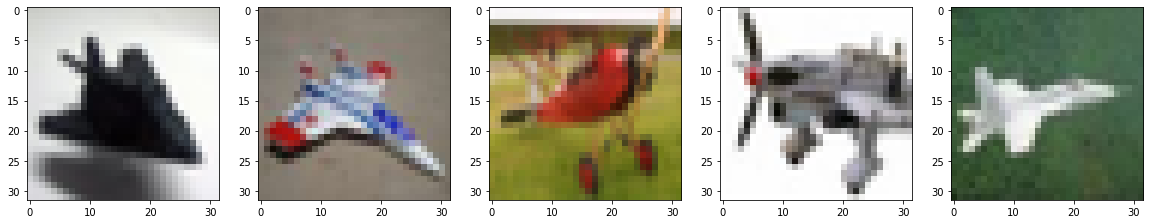

automobile


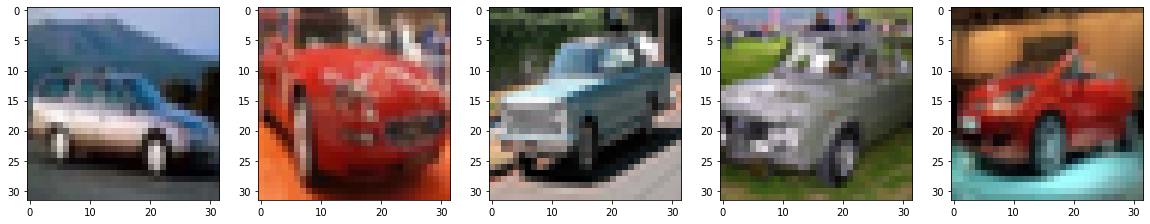

bird


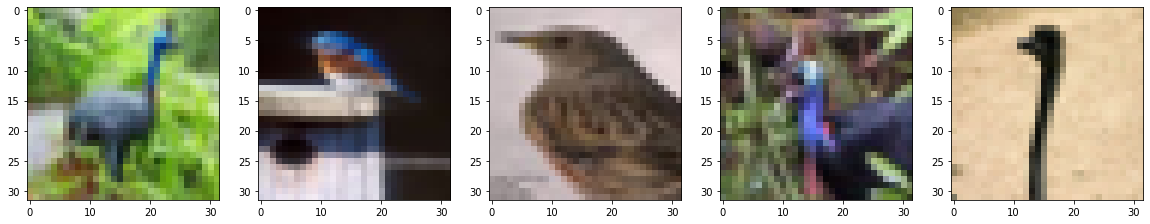

cat


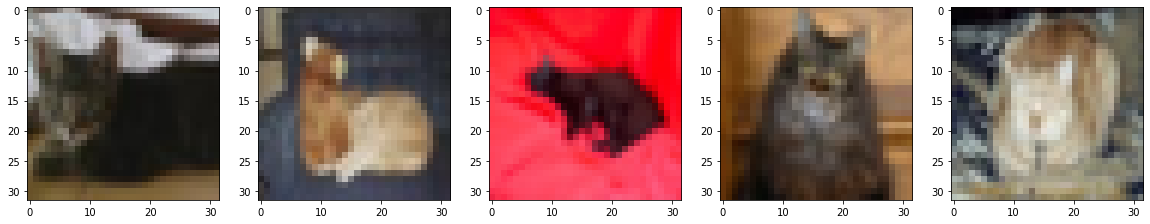

deer


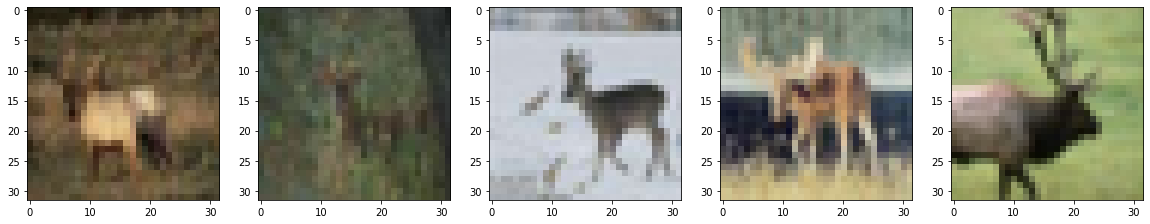

dog


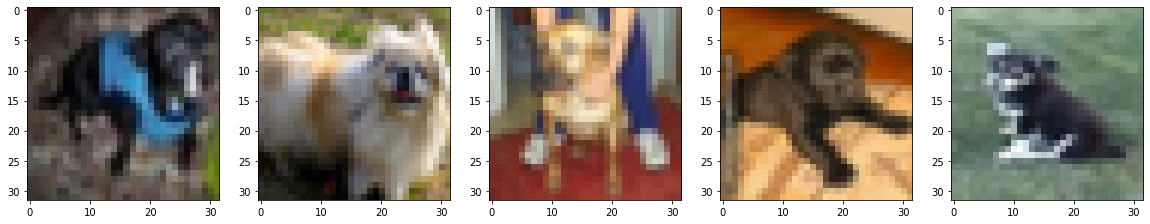

frog


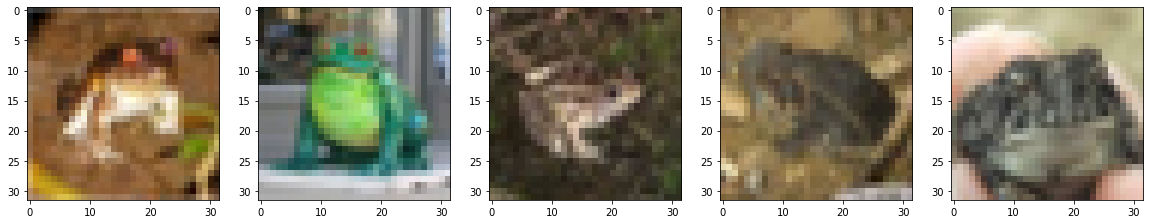

horse


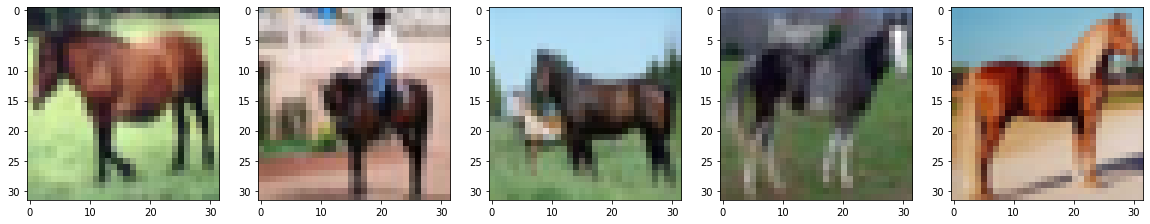

ship


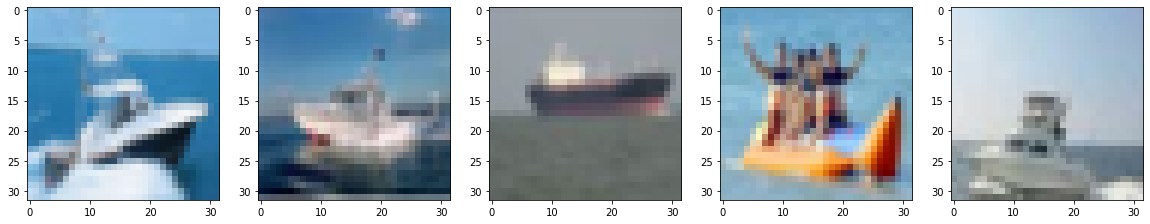

truck


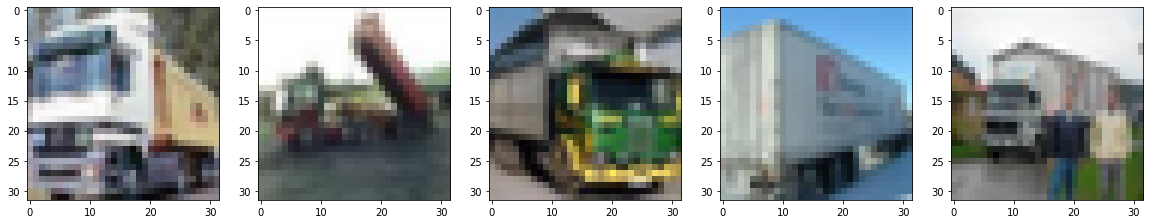

In [10]:
for i in range(0,50,5):
	plt.figure(figsize=(20,4))
	print (Ind2Class[y[i]])
	for j in range(5):
		plt.subplot(1,5,j+1)
		plt.imshow(X[i+j])
	plt.show()

## Q1

### Visualisations of Intermediate Layers

Function for Visualisations

In [11]:
def Visualise(Data, Title):
	print (Title)

	filters = Data.shape[-1]
	plt.figure(figsize=(int(4*filters), 4))

	for k in range(filters):
		plt.subplot(1,filters,k+1)
		plt.imshow(Data[0,:,:,k], cmap='jet')
	
	plt.show()

Visualising

Output Shape: (1, 10)
--------------------------------------------------
1st Convolutional Layer


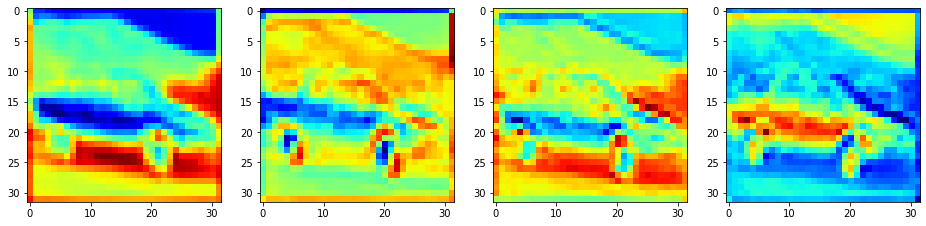

1st Pooling Layer


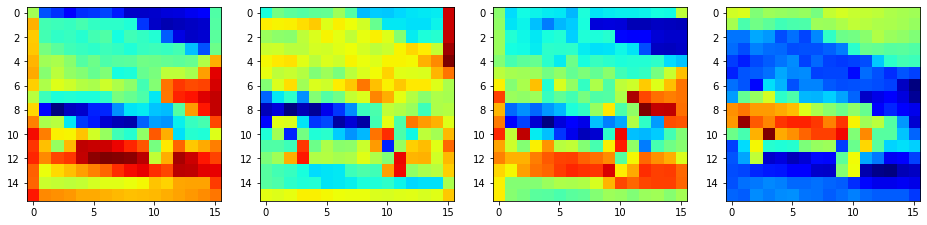

2nd Convolutional Layer


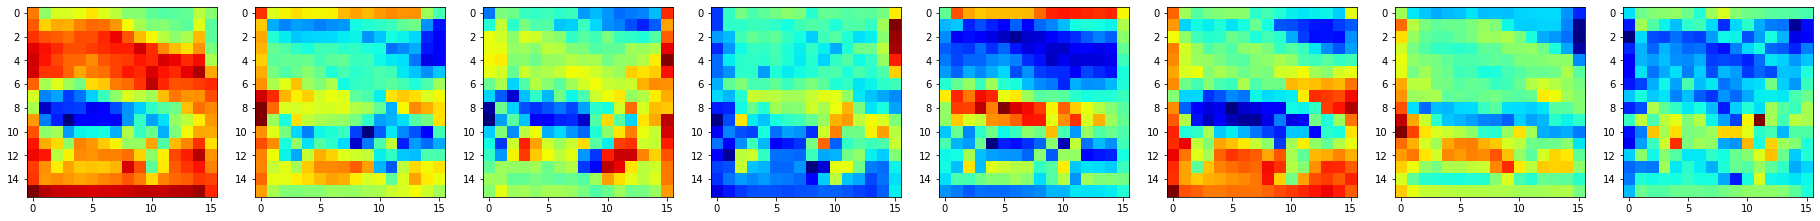

2nd Pooling Layer


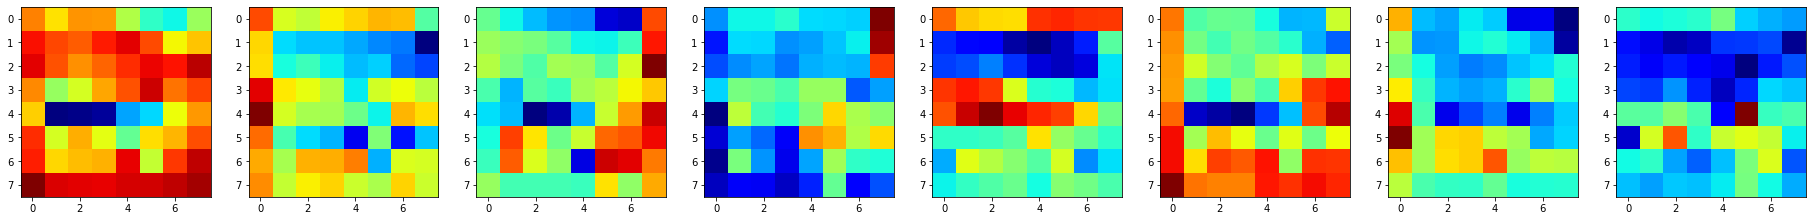

In [12]:
# Intermediate Layers
Output, Intermediate_Layers = Model(np.expand_dims(X[5], axis=0))
print ("Output Shape:", Output.shape)
print ("-"*50)

# Plotting Intemediate Layers
Visualise(Intermediate_Layers[1], "1st Convolutional Layer")
Visualise(Intermediate_Layers[2], "1st Pooling Layer")
Visualise(Intermediate_Layers[3], "2nd Convolutional Layer")
Visualise(Intermediate_Layers[4], "2nd Pooling Layer")

### t-SNE plots

Function to Visualise t-SNE plots

In [13]:
def VisualiseData(Data,y):
	# Visualising Data
	fig = plt.figure(figsize=(8,8))

	if Data.shape[1] == 3:
		ax = fig.add_subplot(111, projection='3d')
		ax.scatter(Data[:,0], Data[:,1], Data[:,2], c=y, cmap="jet")
	else:
		plt.scatter(Data[:,0], Data[:,1], c=y, cmap='jet')
		
	plt.show()

Plotting Results

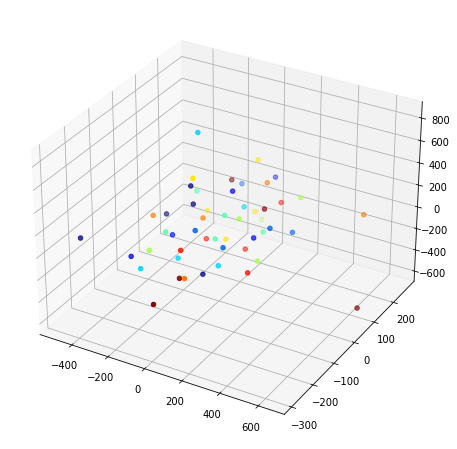

In [14]:
# Predicting
Output, Intermediate_Layers = Model(X)

# t-SNE Embedding
tsne = TSNE(n_components=3)
X_Embedded = tsne.fit_transform(Intermediate_Layers[5])

# Visualise Data
VisualiseData(X_Embedded, y)